In [1]:
import sys
import torch
import pandas as pd
from pathlib import Path

# Add src folder to the Python path
sys.path.append('../src')

from model import SpectrogramResNet
from data_setup import create_logo_dataloaders

from train import train_step, val_step, EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau

c:\Users\ayush\miniconda3\envs\audio-mlops\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torchaudio.transforms as T

# Configuration for the final model
DATA_DIR = "../data/processed/fan"
MODEL_PATH = "../models/production_model.pth"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1 # We only need a small validation set to monitor training
RANDOM_SEED = 42

# Define separate transforms for training and validation
# Data augmentations are applied only to the training data.
train_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),

    # SpecAugment: Randomly mask out a vertical band (time), simulates audio dropouts.
    T.TimeMasking(time_mask_param=80),

    # SpecAugment: Randomly mask out a horizontal band (frequency), simulates noise.
    T.FrequencyMasking(freq_mask_param=80),

    # Normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation set is not augmented, gives a stable measure of model performance during training.
validation_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create two dataset instances, one for training and one for validation
# Necessary because they have different transform pipelines
train_full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transforms)
val_full_dataset = datasets.ImageFolder(DATA_DIR, transform=validation_transforms)

# Correct the labels for both datasets
correct_class_to_idx = {'abnormal': 0, 'normal': 1}

def correct_dataset_labels(dataset, class_map):
    """Helper function to correct labels in a PyTorch dataset."""
    corrected_samples = []
    for path, _ in dataset.samples:
        label = class_map['abnormal'] if 'abnormal' in path else class_map['normal']
        corrected_samples.append((path, label))

    dataset.samples = corrected_samples
    dataset.targets = [s[1] for s in corrected_samples]
    dataset.class_to_idx = class_map
    return dataset

train_full_dataset = correct_dataset_labels(train_full_dataset, correct_class_to_idx)
val_full_dataset = correct_dataset_labels(val_full_dataset, correct_class_to_idx)


# Create final stratified train/val split
labels = train_full_dataset.targets
indices = list(range(len(labels)))

train_indices, val_indices = train_test_split(
    indices, test_size=VALIDATION_SPLIT, stratify=labels, random_state=RANDOM_SEED
)

# Create Subsets using correct dataset object for each split
train_dataset = Subset(train_full_dataset, train_indices) # Use augmented dataset for training
validation_dataset = Subset(val_full_dataset, val_indices) # Validation set is not augmented

print(f"[FINAL MODEL] Training images: {len(train_dataset)}")
print(f"[FINAL MODEL] Validation images: {len(validation_dataset)}")

# Create Final DataLoaders
final_train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
final_val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoaders with data augmentation are ready.")

[FINAL MODEL] Training images: 4995
[FINAL MODEL] Validation images: 555

DataLoaders with data augmentation are ready.


In [ ]:
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from pathlib import Path

# Final Training
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CONFIG = {
    "num_epochs": 100,
    "learning_rate": 1e-4,
    "dropout_rate": 0.4,
    "patience": 15
}

# Training setup
print(f"--- Training final production model on device: {DEVICE} ---")

model = SpectrogramResNet(num_classes=1, dropout_rate=CONFIG["dropout_rate"]).to(DEVICE)
train_labels = [final_train_loader.dataset.dataset.targets[i] for i in final_train_loader.dataset.indices]
num_abnormal = sum(1 for label in train_labels if label == correct_class_to_idx['abnormal'])
num_normal = len(train_labels) - num_abnormal
weight_for_abnormal = num_normal / num_abnormal if num_abnormal > 0 else 1.0

print(f"[FINAL MODEL] Abnormal weight: {weight_for_abnormal:.2f}")

pos_weight_tensor = torch.tensor([weight_for_abnormal], device=DEVICE)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
early_stopper = EarlyStopping(patience=CONFIG["patience"], verbose=True, path=MODEL_PATH)
history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': [], 'val_recall': []}

# Final Training Loop
for epoch in range(CONFIG["num_epochs"]):
    train_loss, _, _, _, train_f1 = train_step(model, final_train_loader, loss_fn, optimizer, DEVICE)
    val_loss, _, _, val_recall, val_f1 = val_step(model, final_val_loader, loss_fn, DEVICE)
    print(f"\nEpoch: {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    history['val_recall'].append(val_recall)
    scheduler.step(val_loss)
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        print("Early stopping triggered.")
        break


# Convert history to a DataFrame
history_df = pd.DataFrame(history)

# Define a path and save the DataFrame as a pickle file
results_dir = Path("../results")
results_dir.mkdir(parents=True, exist_ok=True) # Create the directory if it doesn't exist
history_save_path = results_dir / "production_model_history.pkl"
history_df.to_pickle(history_save_path)

print(f"\n--- Final Production Model Training Complete ---")
print(f"Production model saved to: {MODEL_PATH}")
print(f"Training history saved to: {history_save_path}")

--- Training final production model on device: cuda ---


c:\Users\ayush\miniconda3\envs\audio-mlops\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[FINAL MODEL] Abnormal weight: 2.76


Validation: 100%|██████████| 18/18 [00:12<00:00,  1.39it/s]



Epoch: 1 | Train Loss: 0.8390 | Val Loss: 0.8925 | Val F1: 0.8462
Validation loss decreased (inf --> 0.892479). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]



Epoch: 2 | Train Loss: 0.7728 | Val Loss: 0.7648 | Val F1: 0.8462
Validation loss decreased (0.892479 --> 0.764760). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.06it/s]



Epoch: 3 | Train Loss: 0.7202 | Val Loss: 0.6940 | Val F1: 0.8462
Validation loss decreased (0.764760 --> 0.693974). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.07it/s]



Epoch: 4 | Train Loss: 0.6954 | Val Loss: 0.6658 | Val F1: 0.8462
Validation loss decreased (0.693974 --> 0.665804). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.07it/s]



Epoch: 5 | Train Loss: 0.6594 | Val Loss: 0.6405 | Val F1: 0.8462
Validation loss decreased (0.665804 --> 0.640463). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  3.99it/s]



Epoch: 6 | Train Loss: 0.6496 | Val Loss: 0.6161 | Val F1: 0.8479
Validation loss decreased (0.640463 --> 0.616087). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.06it/s]



Epoch: 7 | Train Loss: 0.6183 | Val Loss: 0.5935 | Val F1: 0.8497
Validation loss decreased (0.616087 --> 0.593456). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  3.98it/s]



Epoch: 8 | Train Loss: 0.6104 | Val Loss: 0.5747 | Val F1: 0.8550
Validation loss decreased (0.593456 --> 0.574703). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.02it/s]



Epoch: 9 | Train Loss: 0.5971 | Val Loss: 0.5406 | Val F1: 0.8605
Validation loss decreased (0.574703 --> 0.540590). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.03it/s]



Epoch: 10 | Train Loss: 0.5893 | Val Loss: 0.5347 | Val F1: 0.8675
Validation loss decreased (0.540590 --> 0.534669). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.08it/s]



Epoch: 11 | Train Loss: 0.5792 | Val Loss: 0.5193 | Val F1: 0.8666
Validation loss decreased (0.534669 --> 0.519261). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.26it/s]



Epoch: 12 | Train Loss: 0.5769 | Val Loss: 0.5259 | Val F1: 0.8778
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.18it/s]



Epoch: 13 | Train Loss: 0.5673 | Val Loss: 0.5182 | Val F1: 0.8797
Validation loss decreased (0.519261 --> 0.518247). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.11it/s]



Epoch: 14 | Train Loss: 0.5759 | Val Loss: 0.4979 | Val F1: 0.8807
Validation loss decreased (0.518247 --> 0.497869). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  3.98it/s]



Epoch: 15 | Train Loss: 0.5588 | Val Loss: 0.4781 | Val F1: 0.8833
Validation loss decreased (0.497869 --> 0.478131). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.02it/s]



Epoch: 16 | Train Loss: 0.5247 | Val Loss: 0.4733 | Val F1: 0.8850
Validation loss decreased (0.478131 --> 0.473335). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.24it/s]



Epoch: 17 | Train Loss: 0.5189 | Val Loss: 0.4732 | Val F1: 0.8857
Validation loss decreased (0.473335 --> 0.473229). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.26it/s]



Epoch: 18 | Train Loss: 0.5415 | Val Loss: 0.4861 | Val F1: 0.8931
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.26it/s]



Epoch: 19 | Train Loss: 0.5308 | Val Loss: 0.4853 | Val F1: 0.8921
EarlyStopping counter: 2 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.28it/s]



Epoch: 20 | Train Loss: 0.5379 | Val Loss: 0.4462 | Val F1: 0.8840
Validation loss decreased (0.473229 --> 0.446244). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.26it/s]



Epoch: 21 | Train Loss: 0.5227 | Val Loss: 0.4625 | Val F1: 0.9000
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.19it/s]



Epoch: 22 | Train Loss: 0.5256 | Val Loss: 0.4353 | Val F1: 0.8797
Validation loss decreased (0.446244 --> 0.435348). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.24it/s]



Epoch: 23 | Train Loss: 0.4948 | Val Loss: 0.4431 | Val F1: 0.8950
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.18it/s]



Epoch: 24 | Train Loss: 0.4871 | Val Loss: 0.4090 | Val F1: 0.9055
Validation loss decreased (0.435348 --> 0.408990). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.17it/s]



Epoch: 25 | Train Loss: 0.5042 | Val Loss: 0.4201 | Val F1: 0.9012
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.19it/s]



Epoch: 26 | Train Loss: 0.4852 | Val Loss: 0.4197 | Val F1: 0.9109
EarlyStopping counter: 2 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.22it/s]



Epoch: 27 | Train Loss: 0.4874 | Val Loss: 0.4352 | Val F1: 0.8972
EarlyStopping counter: 3 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  3.98it/s]



Epoch: 28 | Train Loss: 0.4994 | Val Loss: 0.4866 | Val F1: 0.9046
EarlyStopping counter: 4 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.15it/s]



Epoch: 29 | Train Loss: 0.4862 | Val Loss: 0.4409 | Val F1: 0.9038
EarlyStopping counter: 5 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.18it/s]



Epoch: 30 | Train Loss: 0.4752 | Val Loss: 0.3892 | Val F1: 0.9042
Validation loss decreased (0.408990 --> 0.389230). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.16it/s]



Epoch: 31 | Train Loss: 0.4704 | Val Loss: 0.4154 | Val F1: 0.8884
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.24it/s]



Epoch: 32 | Train Loss: 0.4799 | Val Loss: 0.4099 | Val F1: 0.9056
EarlyStopping counter: 2 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.24it/s]



Epoch: 33 | Train Loss: 0.4569 | Val Loss: 0.4095 | Val F1: 0.9149
EarlyStopping counter: 3 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.26it/s]



Epoch: 34 | Train Loss: 0.4473 | Val Loss: 0.4118 | Val F1: 0.9143
EarlyStopping counter: 4 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.22it/s]



Epoch: 35 | Train Loss: 0.4554 | Val Loss: 0.3691 | Val F1: 0.9122
Validation loss decreased (0.389230 --> 0.369063). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.24it/s]



Epoch: 36 | Train Loss: 0.4434 | Val Loss: 0.4083 | Val F1: 0.9187
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.20it/s]



Epoch: 37 | Train Loss: 0.4576 | Val Loss: 0.3740 | Val F1: 0.9215
EarlyStopping counter: 2 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.09it/s]



Epoch: 38 | Train Loss: 0.4525 | Val Loss: 0.3941 | Val F1: 0.9105
EarlyStopping counter: 3 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.18it/s]



Epoch: 39 | Train Loss: 0.4360 | Val Loss: 0.3932 | Val F1: 0.9147
EarlyStopping counter: 4 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.11it/s]



Epoch: 40 | Train Loss: 0.4402 | Val Loss: 0.3770 | Val F1: 0.9149
EarlyStopping counter: 5 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.07it/s]



Epoch: 41 | Train Loss: 0.4267 | Val Loss: 0.3582 | Val F1: 0.9245
Validation loss decreased (0.369063 --> 0.358228). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.04it/s]



Epoch: 42 | Train Loss: 0.4307 | Val Loss: 0.3723 | Val F1: 0.9166
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.02it/s]



Epoch: 43 | Train Loss: 0.4420 | Val Loss: 0.3732 | Val F1: 0.9211
EarlyStopping counter: 2 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.08it/s]



Epoch: 44 | Train Loss: 0.4209 | Val Loss: 0.3389 | Val F1: 0.9161
Validation loss decreased (0.358228 --> 0.338892). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.09it/s]



Epoch: 45 | Train Loss: 0.4248 | Val Loss: 0.3534 | Val F1: 0.9350
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.05it/s]



Epoch: 46 | Train Loss: 0.4182 | Val Loss: 0.3598 | Val F1: 0.9329
EarlyStopping counter: 2 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.05it/s]



Epoch: 47 | Train Loss: 0.4117 | Val Loss: 0.3476 | Val F1: 0.9340
EarlyStopping counter: 3 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.01it/s]



Epoch: 48 | Train Loss: 0.4362 | Val Loss: 0.3251 | Val F1: 0.9287
Validation loss decreased (0.338892 --> 0.325122). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.06it/s]



Epoch: 49 | Train Loss: 0.4067 | Val Loss: 0.3380 | Val F1: 0.9261
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.04it/s]



Epoch: 50 | Train Loss: 0.4109 | Val Loss: 0.3672 | Val F1: 0.9295
EarlyStopping counter: 2 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.06it/s]



Epoch: 51 | Train Loss: 0.4128 | Val Loss: 0.3598 | Val F1: 0.9295
EarlyStopping counter: 3 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.01it/s]



Epoch: 52 | Train Loss: 0.4089 | Val Loss: 0.3312 | Val F1: 0.9194
EarlyStopping counter: 4 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.00it/s]



Epoch: 53 | Train Loss: 0.3992 | Val Loss: 0.3563 | Val F1: 0.9347
EarlyStopping counter: 5 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.11it/s]



Epoch: 54 | Train Loss: 0.4026 | Val Loss: 0.3212 | Val F1: 0.9319
Validation loss decreased (0.325122 --> 0.321197). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.10it/s]



Epoch: 55 | Train Loss: 0.4142 | Val Loss: 0.3528 | Val F1: 0.9460
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.13it/s]



Epoch: 56 | Train Loss: 0.3896 | Val Loss: 0.3367 | Val F1: 0.9326
EarlyStopping counter: 2 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  3.97it/s]



Epoch: 57 | Train Loss: 0.4061 | Val Loss: 0.3261 | Val F1: 0.9245
EarlyStopping counter: 3 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.15it/s]



Epoch: 58 | Train Loss: 0.4031 | Val Loss: 0.3086 | Val F1: 0.9355
Validation loss decreased (0.321197 --> 0.308604). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.25it/s]



Epoch: 59 | Train Loss: 0.3839 | Val Loss: 0.2983 | Val F1: 0.9439
Validation loss decreased (0.308604 --> 0.298304). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.18it/s]



Epoch: 60 | Train Loss: 0.4102 | Val Loss: 0.3219 | Val F1: 0.9350
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.21it/s]



Epoch: 61 | Train Loss: 0.3919 | Val Loss: 0.3215 | Val F1: 0.9383
EarlyStopping counter: 2 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.19it/s]



Epoch: 62 | Train Loss: 0.3924 | Val Loss: 0.3230 | Val F1: 0.9319
EarlyStopping counter: 3 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.15it/s]



Epoch: 63 | Train Loss: 0.3703 | Val Loss: 0.3067 | Val F1: 0.9254
EarlyStopping counter: 4 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.08it/s]



Epoch: 64 | Train Loss: 0.3923 | Val Loss: 0.3211 | Val F1: 0.9324
EarlyStopping counter: 5 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.25it/s]



Epoch: 65 | Train Loss: 0.3675 | Val Loss: 0.3311 | Val F1: 0.9340
EarlyStopping counter: 6 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.19it/s]



Epoch: 66 | Train Loss: 0.3844 | Val Loss: 0.3125 | Val F1: 0.9397
EarlyStopping counter: 7 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.18it/s]



Epoch: 67 | Train Loss: 0.3802 | Val Loss: 0.2934 | Val F1: 0.9363
Validation loss decreased (0.298304 --> 0.293432). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.17it/s]



Epoch: 68 | Train Loss: 0.3980 | Val Loss: 0.3149 | Val F1: 0.9343
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.20it/s]



Epoch: 69 | Train Loss: 0.3755 | Val Loss: 0.2991 | Val F1: 0.9330
EarlyStopping counter: 2 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.09it/s]



Epoch: 70 | Train Loss: 0.3535 | Val Loss: 0.3115 | Val F1: 0.9428
EarlyStopping counter: 3 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.02it/s]



Epoch: 71 | Train Loss: 0.3620 | Val Loss: 0.3056 | Val F1: 0.9375
EarlyStopping counter: 4 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.14it/s]



Epoch: 72 | Train Loss: 0.3577 | Val Loss: 0.3134 | Val F1: 0.9349
EarlyStopping counter: 5 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.13it/s]



Epoch: 73 | Train Loss: 0.3795 | Val Loss: 0.3298 | Val F1: 0.9341
EarlyStopping counter: 6 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.11it/s]



Epoch: 74 | Train Loss: 0.3778 | Val Loss: 0.3143 | Val F1: 0.9296
EarlyStopping counter: 7 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.08it/s]



Epoch: 75 | Train Loss: 0.3792 | Val Loss: 0.2988 | Val F1: 0.9375
EarlyStopping counter: 8 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.04it/s]



Epoch: 76 | Train Loss: 0.3746 | Val Loss: 0.3268 | Val F1: 0.9254
EarlyStopping counter: 9 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.07it/s]



Epoch: 77 | Train Loss: 0.3711 | Val Loss: 0.3203 | Val F1: 0.9340
EarlyStopping counter: 10 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.09it/s]



Epoch: 78 | Train Loss: 0.3603 | Val Loss: 0.2853 | Val F1: 0.9431
Validation loss decreased (0.293432 --> 0.285307). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.10it/s]



Epoch: 79 | Train Loss: 0.3621 | Val Loss: 0.3006 | Val F1: 0.9340
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.05it/s]



Epoch: 80 | Train Loss: 0.3767 | Val Loss: 0.2946 | Val F1: 0.9408
EarlyStopping counter: 2 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.12it/s]



Epoch: 81 | Train Loss: 0.3662 | Val Loss: 0.2983 | Val F1: 0.9366
EarlyStopping counter: 3 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.11it/s]



Epoch: 82 | Train Loss: 0.3935 | Val Loss: 0.2916 | Val F1: 0.9310
EarlyStopping counter: 4 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.09it/s]



Epoch: 83 | Train Loss: 0.3804 | Val Loss: 0.2797 | Val F1: 0.9387
Validation loss decreased (0.285307 --> 0.279668). Saving model...


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.21it/s]



Epoch: 84 | Train Loss: 0.3766 | Val Loss: 0.2976 | Val F1: 0.9376
EarlyStopping counter: 1 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.15it/s]



Epoch: 85 | Train Loss: 0.3673 | Val Loss: 0.3261 | Val F1: 0.9307
EarlyStopping counter: 2 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.23it/s]



Epoch: 86 | Train Loss: 0.3699 | Val Loss: 0.2988 | Val F1: 0.9338
EarlyStopping counter: 3 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.19it/s]



Epoch: 87 | Train Loss: 0.3754 | Val Loss: 0.2987 | Val F1: 0.9431
EarlyStopping counter: 4 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.23it/s]



Epoch: 88 | Train Loss: 0.3567 | Val Loss: 0.2913 | Val F1: 0.9371
EarlyStopping counter: 5 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.14it/s]



Epoch: 89 | Train Loss: 0.3626 | Val Loss: 0.3140 | Val F1: 0.9291
EarlyStopping counter: 6 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.11it/s]



Epoch: 90 | Train Loss: 0.3698 | Val Loss: 0.3068 | Val F1: 0.9319
EarlyStopping counter: 7 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.27it/s]



Epoch: 91 | Train Loss: 0.3634 | Val Loss: 0.3266 | Val F1: 0.9309
EarlyStopping counter: 8 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.16it/s]



Epoch: 92 | Train Loss: 0.3888 | Val Loss: 0.2852 | Val F1: 0.9463
EarlyStopping counter: 9 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.31it/s]



Epoch: 93 | Train Loss: 0.3838 | Val Loss: 0.3102 | Val F1: 0.9341
EarlyStopping counter: 10 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.18it/s]



Epoch: 94 | Train Loss: 0.3535 | Val Loss: 0.3018 | Val F1: 0.9384
EarlyStopping counter: 11 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.27it/s]



Epoch: 95 | Train Loss: 0.3954 | Val Loss: 0.3062 | Val F1: 0.9384
EarlyStopping counter: 12 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.20it/s]



Epoch: 96 | Train Loss: 0.3542 | Val Loss: 0.3159 | Val F1: 0.9298
EarlyStopping counter: 13 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.18it/s]



Epoch: 97 | Train Loss: 0.3767 | Val Loss: 0.3220 | Val F1: 0.9273
EarlyStopping counter: 14 out of 15


Validation: 100%|██████████| 18/18 [00:04<00:00,  4.04it/s]


Epoch: 98 | Train Loss: 0.3774 | Val Loss: 0.3217 | Val F1: 0.9295
EarlyStopping counter: 15 out of 15
Early stopping triggered.

--- Final Production Model Training Complete ---
Production model saved to: ../models/production_model.pth
Training history saved to: ..\results\production_model_history.pkl


: 

Training history loaded successfully.


,train_loss,train_f1,val_loss,val_f1,val_recall
0,0.839012,0.846314,0.892479,0.846154,1.000000
1,0.772786,0.846820,0.764760,0.846154,1.000000
2,0.720227,0.846918,0.693974,0.846154,1.000000
3,0.695362,0.848078,0.665804,0.846154,1.000000
4,0.659382,0.853408,0.640463,0.846154,1.000000
...,...,...,...,...,...
93,0.353524,0.927577,0.301819,0.938444,0.992629
94,0.395401,0.919423,0.306180,0.938444,0.992629
95,0.354188,0.924514,0.315917,0.929804,0.992629
96,0.376692,0.921917,0.322037,0.927336,0.987715


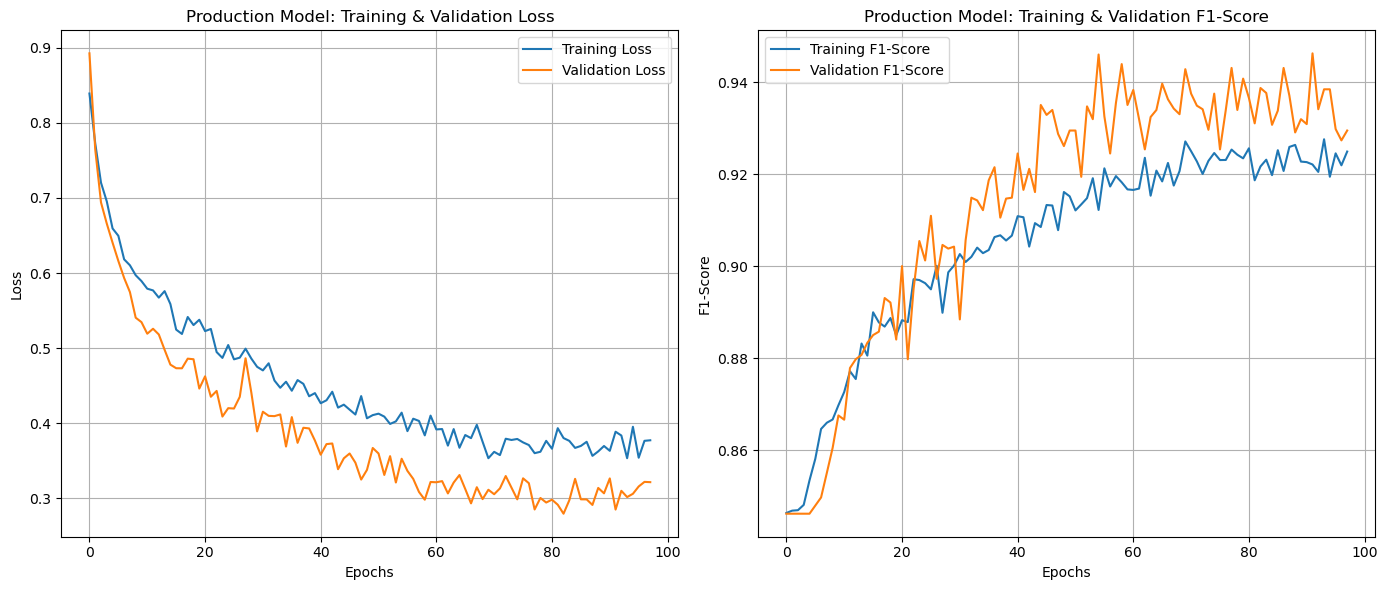

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Load the saved history DataFrame 
results_dir = Path("../results")
history_save_path = results_dir / "production_model_history.pkl"
history_df = pd.read_pickle(history_save_path)

print("Training history loaded successfully.")
display(history_df)

# Plot the results
plt.figure(figsize=(14, 6))

# Plotting the loss curves
plt.subplot(1, 2, 1)
plt.plot(history_df['train_loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Production Model: Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting the F1 score curves
plt.subplot(1, 2, 2)
plt.plot(history_df['train_f1'], label='Training F1-Score')
plt.plot(history_df['val_f1'], label='Validation F1-Score')
plt.title('Production Model: Training & Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

--- Evaluating production model on device: cuda ---


C:\Users\ayush\AppData\Local\Temp\ipykernel_9968\3581095982.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DE


--- Evaluation Complete ---


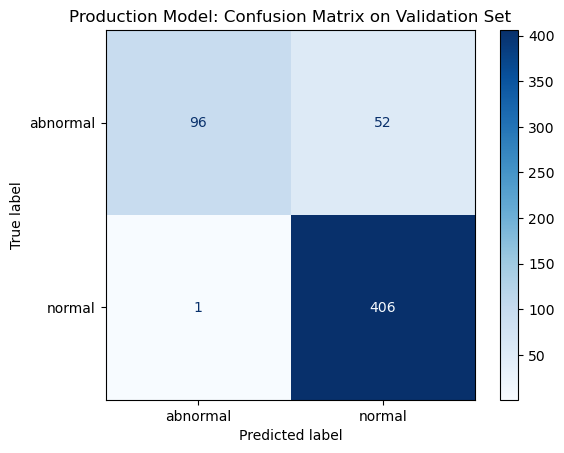

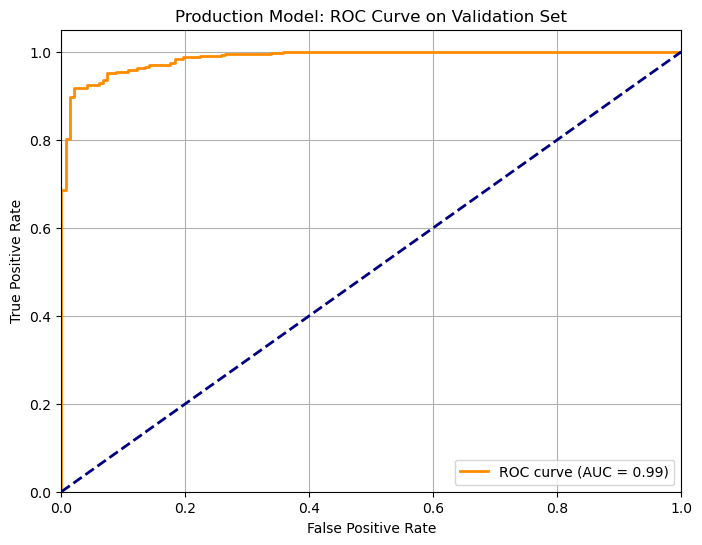

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np

# Setup
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "../models/production_model.pth" # Path to trained production model
CLASS_MAP = {'abnormal': 0, 'normal': 1}
CLASS_NAMES = list(CLASS_MAP.keys())

print(f"--- Evaluating production model on device: {DEVICE} ---")

# Load the Best Production Model 
# Create an instance of the model architecture
model = SpectrogramResNet(num_classes=1).to(DEVICE)
# Load the saved weights into the model instance
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
# Set the model to evaluation mode
model.eval()

# Get Predictions on the Validation Set
all_labels = []
all_preds = []
all_probs = []

# Use the final_val_loader which contains the 10% holdout from all data
with torch.no_grad():
    for X, y in final_val_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        
        y_logits = model(X)
        y_probs = torch.sigmoid(y_logits)
        y_preds = torch.round(y_probs)
        
        all_labels.extend(y.cpu().numpy())
        all_preds.extend(y_preds.cpu().numpy())
        all_probs.extend(y_probs.cpu().numpy())

print("\n--- Evaluation Complete ---")

# Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(cmap=plt.cm.Blues)
plt.title('Production Model: Confusion Matrix on Validation Set')
plt.show()

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Production Model: ROC Curve on Validation Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()